In [ ]:
# --- CORE LIBRARIES ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, models, transforms

In [ ]:
import os
from google.colab import drive


drive.mount('/content/drive', force_remount=True)


data_dir = "/content/drive/MyDrive/Brain Tumor - MRI Scans"


if os.path.exists(data_dir):
    print(" Path Found!")
    print("Folders inside:", os.listdir(data_dir))
else:
    print("Path Not Found. Please check the spelling in your Drive.")


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Training', 'Testing']}

Mounted at /content/drive
✅ Path Found!
Folders inside: ['Testing', 'Training']


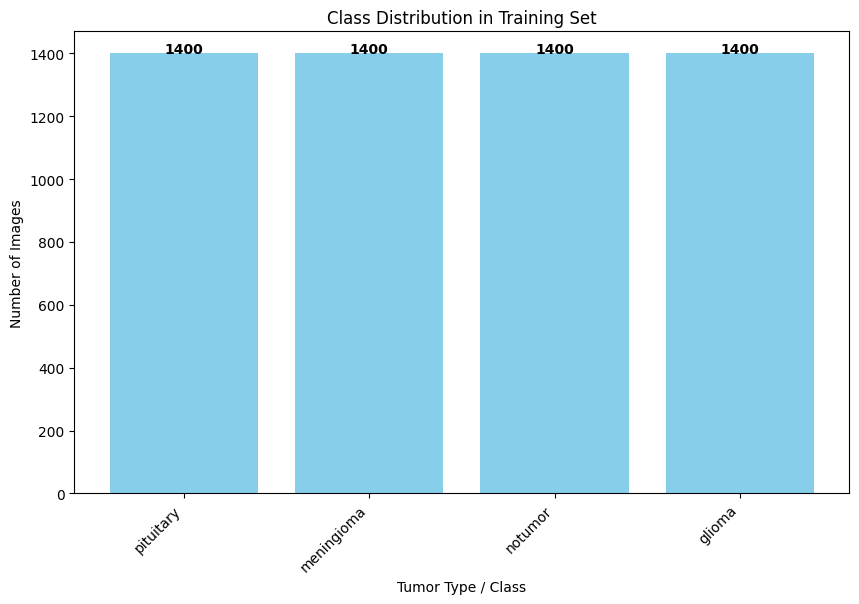

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_class_distribution(data_dir, set_name='Training'):
    path = os.path.join(data_dir, set_name)
    classes = os.listdir(path)

    counts = {}
    for c in classes:
        class_path = os.path.join(path, c)
        if os.path.isdir(class_path):
            counts[c] = len(os.listdir(class_path))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.xlabel('Tumor Type / Class')
    plt.ylabel('Number of Images')
    plt.title(f'Class Distribution in {set_name} Set')
    plt.xticks(rotation=45, ha='right')

    # Add labels on top of bars
    for i, v in enumerate(counts.values()):
        plt.text(i, v + 2, str(v), ha='center', fontweight='bold')

    plt.show()
    return counts

# Run for your Brain Tumor dataset
distribution = plot_class_distribution(data_dir, 'Training')

In [ ]:
# --- 1. SET UP PATHS ---

data_dir = "/content/drive/MyDrive/Brain Tumor - MRI Scans"

# --- 2. DEFINE TRANSFORMS ---

data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- 3. LOAD DATASETS & DATALOADERS ---

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Training', 'Testing']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=(x=='Training'))
              for x in ['Training', 'Testing']}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

# --- 1. MODEL SETUP: EfficientNet-B1 ---
def get_brain_tumor_model(num_classes):

    model = models.efficientnet_b1(weights='IMAGENET1K_V1')

    # Freeze all layers first
    for param in model.parameters():
        param.requires_grad = False

    # UNFREEZE the final stage (blocks[6] and blocks[7]) to improve Grad-CAM localization

    for param in model.features[7].parameters():
        param.requires_grad = True
    for param in model.features[8].parameters(): # The final conv layer (norm layer)
        param.requires_grad = True

    # Updated Classifier with Dropout (0.4) to fight shortcut learning
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(num_ftrs, num_classes)
    )
    return model

# --- 2. INITIALIZATION ---
class_names = image_datasets['Training'].classes
num_classes = len(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_brain_tumor_model(num_classes).to(device)

# --- 3. OPTIMIZER & LOSS ---

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# Maintaining your weighted loss to handle the 3:1 clinical bias
weights = torch.tensor([1.0, 1.0, 3.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

print(f"EfficientNet-B1 ready for {num_classes} classes on {device}")

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth


100%|██████████| 30.1M/30.1M [00:00<00:00, 144MB/s]


✅ EfficientNet-B1 ready for 4 classes on cpu


In [ ]:
# Target the final convolutional layer of EfficientNet-B1
target_layers = [model.features[8]]

In [ ]:
import torch
from tqdm.auto import tqdm
import numpy as np

# --- 1. EARLY STOPPING CLASS ---
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='best_brain_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- 2. THE TRAINING FUNCTION ---
def train_model(model, criterion, optimizer, num_epochs=100, patience=10):

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Progress bar with tqdm
            pbar = tqdm(dataloaders[phase], desc=f"{phase}")

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                # Track gradients only in training phase
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update tqdm description with batch loss
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Check Early Stopping after Validation phase
            if phase == 'Testing':
                early_stopping(epoch_loss, model)

        if early_stopping.early_stop:
            print("Early stopping triggered. Training halted.")
            break

    # Load the best model weights before returning
    model.load_state_dict(torch.load('best_brain_model.pth'))
    return model


trained_model = train_model(model, criterion, optimizer, num_epochs=100)


Epoch 1/100
----------


Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training Loss: 1.1926 Acc: 0.4339


Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Testing Loss: 1.1410 Acc: 0.5887
Validation loss decreased (inf --> 1.140953). Saving model...

Epoch 2/100
----------


Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training Loss: 0.8669 Acc: 0.6371


Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Testing Loss: 0.9968 Acc: 0.7000
Validation loss decreased (1.140953 --> 0.996832). Saving model...

Epoch 3/100
----------


Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training Loss: 0.6841 Acc: 0.7554


Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Testing Loss: 0.8816 Acc: 0.7394
Validation loss decreased (0.996832 --> 0.881649). Saving model...

Epoch 4/100
----------


Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training Loss: 0.5750 Acc: 0.7923


Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Testing Loss: 0.8006 Acc: 0.7612
Validation loss decreased (0.881649 --> 0.800636). Saving model...

Epoch 5/100
----------


Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training Loss: 0.5014 Acc: 0.8154


Testing:   0%|          | 0/50 [00:00<?, ?it/s]

Testing Loss: 0.7728 Acc: 0.7619
Validation loss decreased (0.800636 --> 0.772847). Saving model...

Epoch 6/100
----------


Training:   0%|          | 0/175 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import shutil
import os

# Source: Temporary Colab folder
source = '/content/best_brain_model.pth'

# Destination: Your permanent Hackathon folder
destination = '/content/drive/MyDrive/Vega Hackathon Dataset/best_brain_model.pth'

if os.path.exists(source):
    shutil.copy(source, destination)
    print("Best model successfully backed up to Google Drive!")
else:
    print("The model hasn't saved a 'best' version yet. Wait for an epoch to finish!")

✅ Best model successfully backed up to Google Drive!
